In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer


Datapath = "C:\\Users\\HP\\Downloads\\archive (1)\\"
Datafile = "customer_churn_telecom_services.csv"

df =  pd.read_csv(Datapath + Datafile)

In [5]:
# Handling missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


# Feature engineering
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], 
                          labels=['0-1 Year', '1-2 Years', '2-4 Years', '4-6 Years'])


In [6]:
# Selecting features for clustering
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
           'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
           'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
           'TotalCharges', 'TenureGroup']

# Encoding categorical variables
data = df[features].copy()

# Label encoding for binary variables
binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# One-hot encoding for multi-category variables
data = pd.get_dummies(data, columns=[col for col in features if col not in binary_cols and col not in ['MonthlyCharges', 'TotalCharges']], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

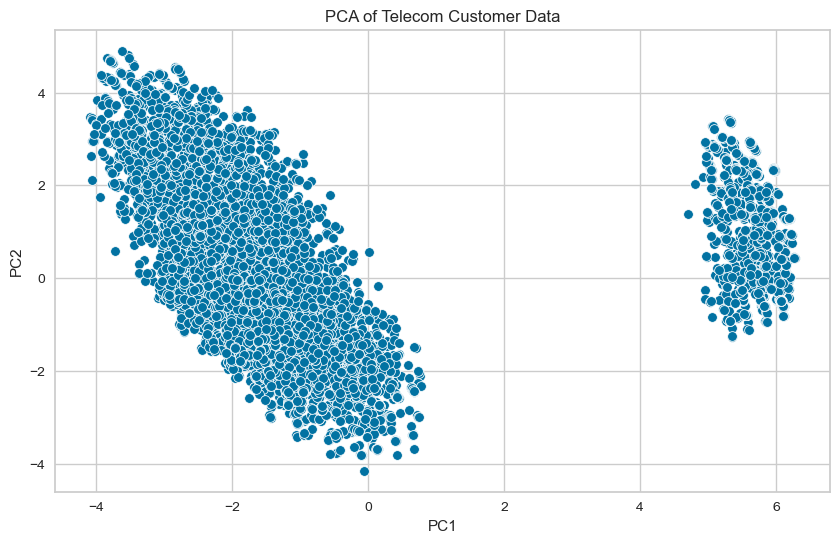

Explained variance ratio: [0.31926738 0.11270444]


In [7]:
# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualize PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA of Telecom Customer Data')
plt.show()

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

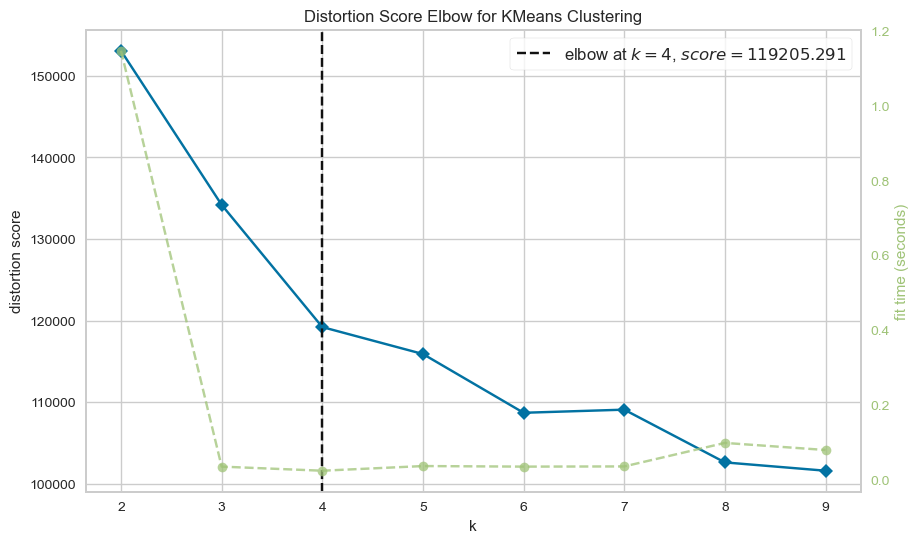

For n_clusters = 2, the silhouette score is 0.156
For n_clusters = 3, the silhouette score is 0.277
For n_clusters = 4, the silhouette score is 0.236
For n_clusters = 5, the silhouette score is 0.208
For n_clusters = 6, the silhouette score is 0.150


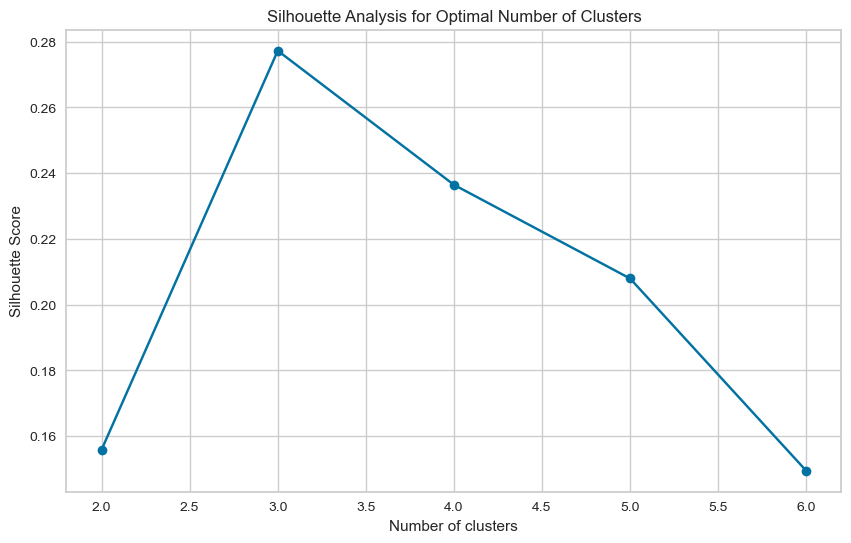

In [8]:
# Elbow method analysis
plt.figure(figsize=(10, 6))
visualizer = KElbowVisualizer(KMeans(), k=(2,10))
visualizer.fit(scaled_data)
visualizer.show()
plt.show()

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.show()

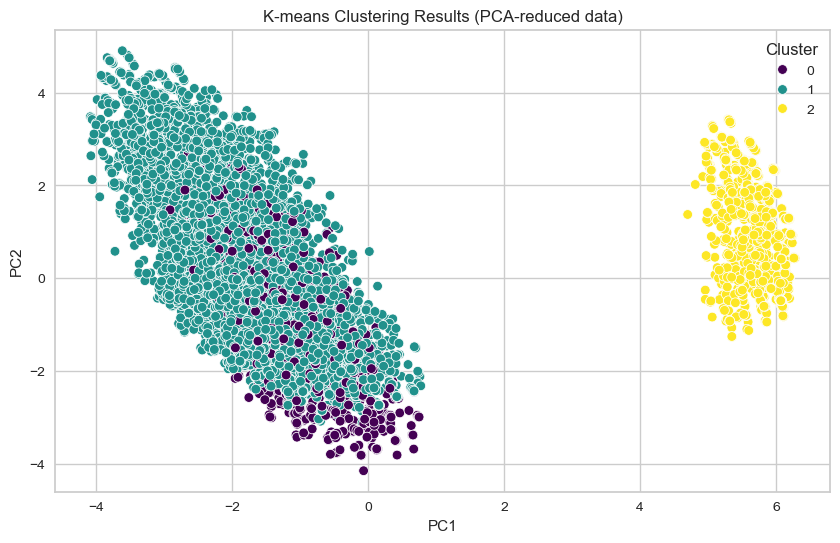

In [9]:
# Perform K-means clustering with optimal number of clusters
optimal_clusters = 3  # Based on elbow and silhouette analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add clusters to PCA dataframe for visualization
pca_df['Cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering Results (PCA-reduced data)')
plt.show()

# Add clusters back to original dataframe
df['Cluster'] = clusters


Cluster Profiles:
   Cluster  MonthlyCharges  TotalCharges     tenure     Churn  Contract  \
0        0       42.028592   1500.131818  31.737537  0.249267  0.551320   
1        1       81.755171   2901.536975  33.036194  0.328025  0.615305   
2        2       21.079194    668.099443  30.547182  0.074050  0.343381   

   InternetService  OnlineSecurity  
0         0.000000        0.585044  
1         0.640331        0.640951  
2         0.000000        0.000000  


C:\Users\HP\AppData\Local\Temp\ipykernel_19044\769403524.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn_numeric'] = df['Churn'].replace({'Yes': 1, 'No': 0})


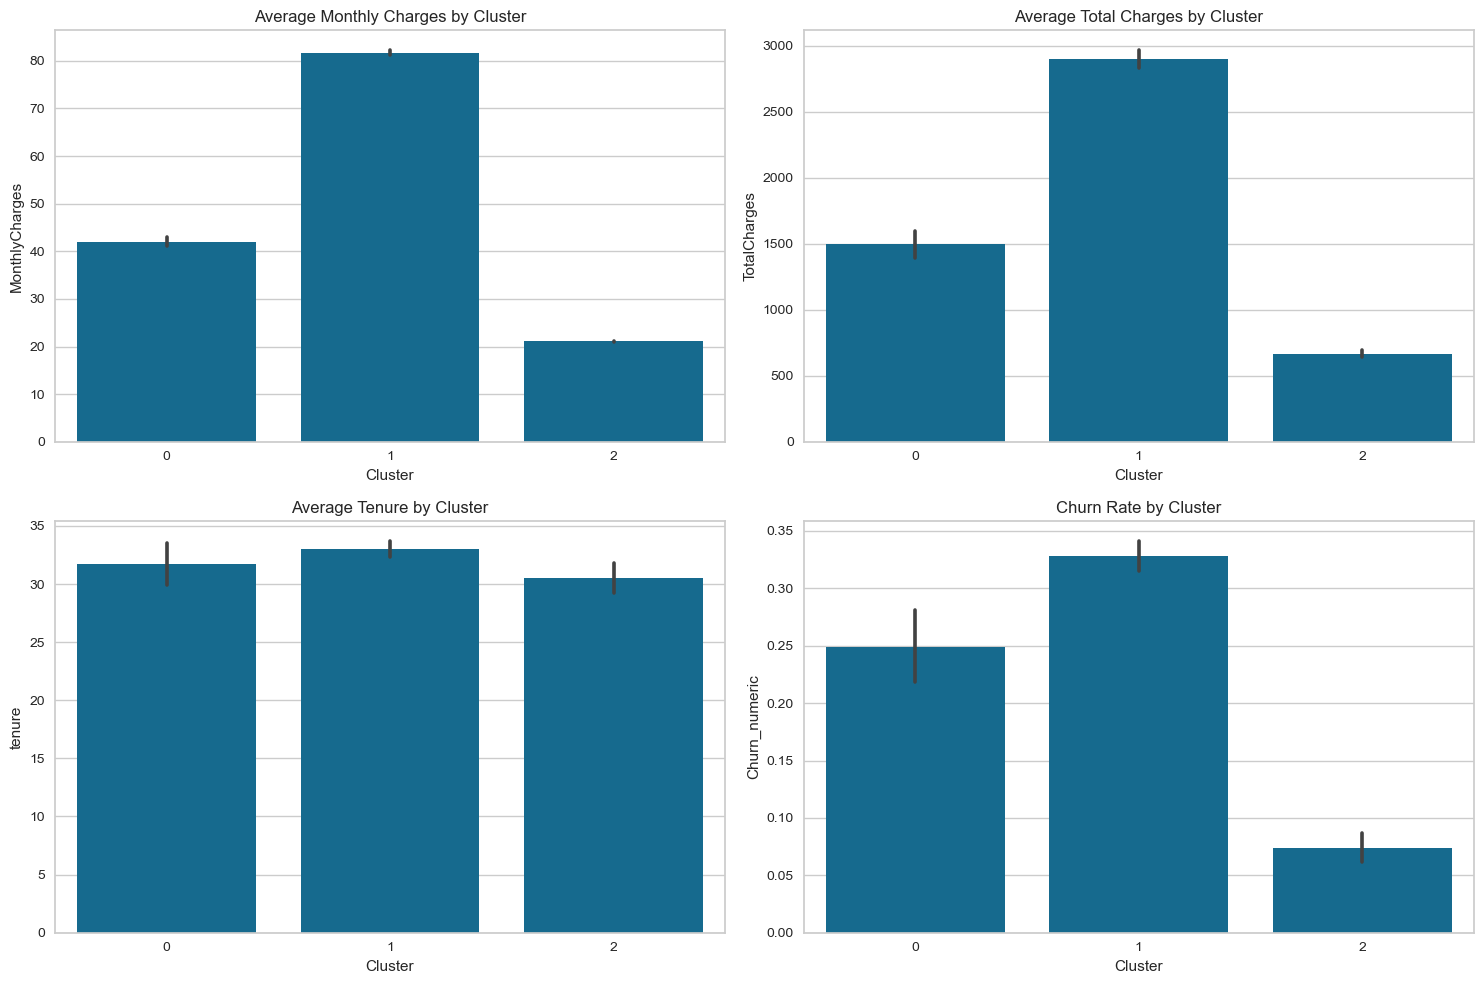

In [14]:
# Analyze cluster characteristics
cluster_profiles = df.groupby('Cluster').agg({
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'tenure': 'mean',
    'Churn': lambda x: (x == 'Yes').mean(),
    'Contract': lambda x: (x == 'Month-to-month').mean(),
    'InternetService': lambda x: (x == 'Fiber optic').mean(),
    'OnlineSecurity': lambda x: (x == 'No').mean()
}).reset_index()

print("\nCluster Profiles:")
print(cluster_profiles)

# Visualize key features by cluster
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='Cluster', y='MonthlyCharges', data=df)
plt.title('Average Monthly Charges by Cluster')

plt.subplot(2, 2, 2)
sns.barplot(x='Cluster', y='TotalCharges', data=df)
plt.title('Average Total Charges by Cluster')

plt.subplot(2, 2, 3)
sns.barplot(x='Cluster', y='tenure', data=df)
plt.title('Average Tenure by Cluster')

plt.subplot(2, 2, 4)
df['Churn_numeric'] = df['Churn'].replace({'Yes': 1, 'No': 0})
sns.barplot(x='Cluster', y='Churn_numeric', data=df)
plt.title('Churn Rate by Cluster')



plt.tight_layout()
plt.show()